Neste notebook:
* Avaliação de usuários por bucket  
    * em média, e mediana, em quantos buckets os utilizadores estão.  
    * quantos usuários novos estão em cada bucket e quantos não ocorrem

Objetivo:
* explorar caracteristicas dos datasets que permitam
    * avaliar se o dataset é util para a análise  
    * escolher o número de buckets  

Vamos definir o numero de itens em cada bucket como 50k

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData
from recommenders_implicit import ISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateAndStore # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout
from dataset_evaluation_utils import * #get_interactions_info, plot_interactions_per_month, plot_user_presence_distribution, plot_n_users_per_bucket, plot_bucket_size

from datetime import datetime, timedelta

import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
# Amazon Books
Small subset, ratings only.  
https://nijianmo.github.io/amazon/index.html


In [3]:
dataset_name = 'Amazon_Books'
user_col = 'user_id'

In [4]:
# data = pd.read_csv('output/amazonbooks_dump/sampled_amazon_books.csv')

In [5]:
# importa dataset 'amazon books'
data = pd.read_csv("../datasets/Books.csv", names=['user_id', 'item_id', 'rating', 'timestamp'])

In [6]:
data.shape

(51311621, 4)

In [7]:
data.head()

,user_id,item_id,rating,timestamp
0,0001713353,A1C6M8LCIX4M6M,5.0,1123804800
1,0001713353,A1REUF3A1YCPHM,5.0,1112140800
2,0001713353,A1YRBRK2XM5D5,5.0,1081036800
3,0001713353,A1V8ZR5P78P4ZU,5.0,1077321600
4,0001713353,A2ZB06582NXCIV,5.0,1475452800


In [8]:
# data['item_id'].nunique() # 15362619

### Keep only high ratings

<AxesSubplot:ylabel='Frequency'>

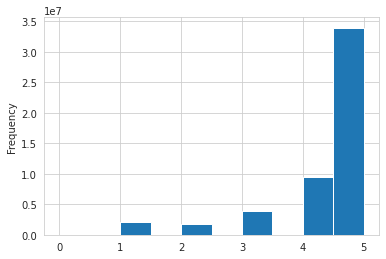

In [9]:
data['rating'].plot(kind='hist')

In [10]:
pos_ratings = np.quantile(data['rating'], q=0.8)

In [11]:
pos_ratings

5.0

In [12]:
data = data[ data['rating'] == pos_ratings ].drop(columns='rating')

In [13]:
# number of remaining cases
data.shape[0]

33979736

### Convert timestamp

In [14]:
%%time
# 56.6 s
data['date'] = data['timestamp'].apply(lambda x: datetime.fromtimestamp(x) ) # convert unix timestamp to date
data = data.sort_values(by='date') # sort by date

CPU times: user 1min 1s, sys: 4.79 s, total: 1min 6s
Wall time: 1min 14s


sampling, only 1st month of 2014

In [15]:
# y_filter = (data['date'] < datetime.strptime('2018', '%Y')) & (datetime.strptime('2014', '%Y') <= data['date']) 
# y_filter = (data['date'] < datetime.strptime('2015-01', '%Y-%m')) & (datetime.strptime('2014-01', '%Y-%m') <= data['date']) 
y_filter = (data['date'] < datetime.strptime('2014-02', '%Y-%m')) & (datetime.strptime('2014-01', '%Y-%m') <= data['date']) 

In [16]:
y_filter.sum()

453122

In [17]:
data = data[y_filter.tolist()]

In [18]:
# number of remaining cases
data.shape[0]

453122

In [19]:
data.head()

,user_id,item_id,timestamp,date
27025546,1493515292,A37V075RLK14A0,1388534400,2014-01-01
6506240,0312352565,A13Q5H80RKIS1B,1388534400,2014-01-01
5871219,0307914208,A15LTMXCREMY4M,1388534400,2014-01-01
25402713,1477817158,A2BZBUV6T8MA6X,1388534400,2014-01-01
33900742,1893910466,A2LNTWNRU7NP06,1388534400,2014-01-01


In [20]:
data.tail()

,user_id,item_id,timestamp,date
12289942,0515142166,A302AHMZFK7GLH,1391126400,2014-01-31
20074523,0988263408,AH59FJI17P6OF,1391126400,2014-01-31
2742922,0071422889,A2UIY4CXY7SCXG,1391126400,2014-01-31
592087,0007518021,ADU6NGG29QD03,1391126400,2014-01-31
7087019,0316069515,AGQFAJJVT2UDQ,1391126400,2014-01-31


In [21]:
%%time
# 102 ms
# keep year-month
data['week'] = data['date'].dt.week#.apply(lambda x: datetime.strptime( str(x.year)+'-'+str(x.month), '%Y-%m' ))

CPU times: user 70.8 ms, sys: 479 µs, total: 71.3 ms
Wall time: 70.7 ms


## Evaluating Time defined Buckets 

Sampling the dataset

CPU times: user 302 ms, sys: 4.2 ms, total: 306 ms
Wall time: 313 ms


<AxesSubplot:xlabel='week'>

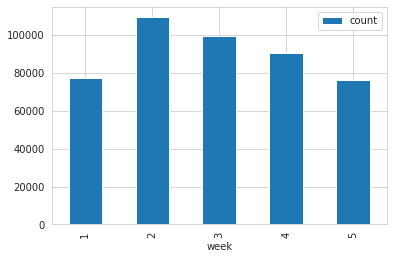

In [22]:
%%time
# interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
# interactions_per_month.name = 'count'
# interactions_per_month=interactions_per_month.reset_index()

interactions_per_week = data.groupby(by=['week']).count().iloc[:, 0]
interactions_per_week.name = 'count'
interactions_per_week=interactions_per_week.reset_index()

# _ = interactions_per_month.copy()
# _['date'] = _['date'].dt.year
# _.groupby('date').sum().plot(kind='bar')
_ = interactions_per_week.copy()
# _['date'] = _['date'].dt.year
_.groupby('week').sum().plot(kind='bar')

Filter only first 3 weeks

In [23]:
data = data[ data['week'] <= 3 ]

**Sampling the dataset - only most frequent users**

In [24]:
%%time
# ( data[:1000000].groupby(by=['user_id'])['date'].nunique() > 1 ).sum()
# user_freq_over_months = data.groupby(by=['user_id'])['date'].nunique()
user_freq_over_week = data.groupby(by=['user_id'])['week'].nunique()

CPU times: user 368 ms, sys: 416 µs, total: 368 ms
Wall time: 367 ms


<AxesSubplot:ylabel='Frequency'>

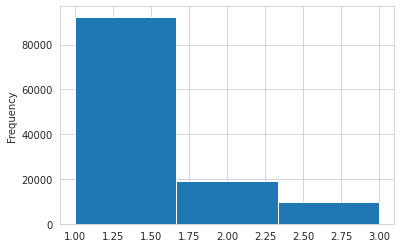

In [25]:
# user_freq_over_months.plot(kind='hist',bins=user_freq_over_months.max())
user_freq_over_week.plot(kind='hist',bins=user_freq_over_week.max())

In [26]:
# sample the dataset to contain only interactions from frequent users (that occur every month).
# there is still a huge number of interactions - 1694351
# _ = data.set_index('user_id').loc[freq_users]
# _.shape
_ = data.set_index('user_id').copy()

<AxesSubplot:>

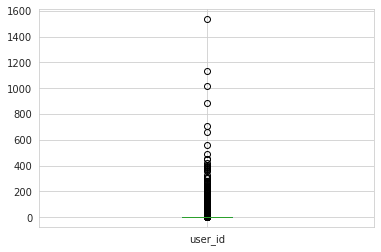

In [27]:
# frequency of users:
_.reset_index()['user_id'].value_counts().plot(kind='box')

In [28]:
u = data['user_id'].value_counts().reset_index()['index'].to_list()

In [29]:
# to use, or not to use p ?
p = (data['user_id'].value_counts()/data['user_id'].shape[0])

In [30]:
prop = 0.5 # careful
s = round( len( u )*prop )

In [31]:
np.random.seed(42)
sampled_users = list( np.random.choice(u, size=s, replace=False, p=p) ) # , p=p

In [32]:
_.loc[sampled_users]

,item_id,timestamp,date,week
user_id,,,,
0892969911,ASI9KLAZ0IIXB,1388707200,2014-01-03,1
0892969911,A2I8R82NFOYJG2,1388793600,2014-01-04,1
0892969911,A5AGPUR4P63U7,1389052800,2014-01-07,2
0892969911,A2V2SA0X4ERJ2Z,1389052800,2014-01-07,2
0892969911,A264ORJJU5DKK9,1389139200,2014-01-08,2
...,...,...,...,...
1118170342,AI401GOJEHS9A,1389052800,2014-01-07,2
0758246684,A2OZPJDWOIXEQV,1389398400,2014-01-11,2
1493730762,A25KE9FYP5S872,1389484800,2014-01-12,2


In [33]:
_.loc[sampled_users]['item_id'].nunique()

164441

<AxesSubplot:>

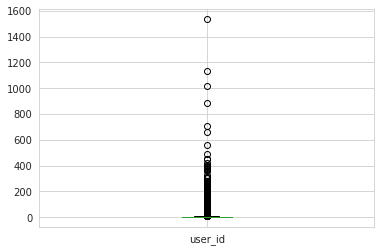

In [34]:
# frequency of users:
_.loc[sampled_users].reset_index()['user_id'].value_counts().plot(kind='box')

CPU times: user 689 ms, sys: 464 µs, total: 690 ms
Wall time: 687 ms


<AxesSubplot:ylabel='Frequency'>

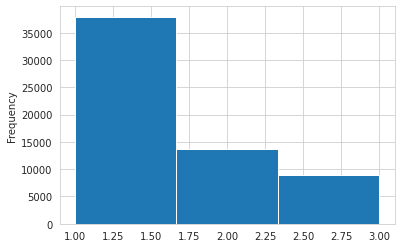

In [35]:
%%time
# ( data[:1000000].groupby(by=['user_id'])['date'].nunique() > 1 ).sum()
# user_freq_over_months_sample = _.loc[sampled_users].reset_index().groupby(by=['user_id'])['date'].nunique()
# user_freq_over_months_sample.plot(kind='hist',bins=user_freq_over_months_sample.max())

user_freq_over_weeks_sample = _.loc[sampled_users].reset_index().groupby(by=['user_id'])['week'].nunique()
user_freq_over_weeks_sample.plot(kind='hist',bins=user_freq_over_weeks_sample.max())

In [36]:
# RERUN THIS
data['user_id'].nunique(), data['item_id'].nunique() # original number of users, original number of items

(121060, 209592)

In [37]:
# _.loc[freq_users].reset_index()['user_id'].nunique(), _.loc[freq_users].reset_index()['item_id'].nunique() # sample number of users, and of items
_.loc[sampled_users].reset_index()['user_id'].nunique(), _.loc[sampled_users].reset_index()['item_id'].nunique() # sample number of users, and of items

(60530, 164441)

CPU times: user 602 ms, sys: 7.3 ms, total: 609 ms
Wall time: 635 ms


<AxesSubplot:xlabel='week'>

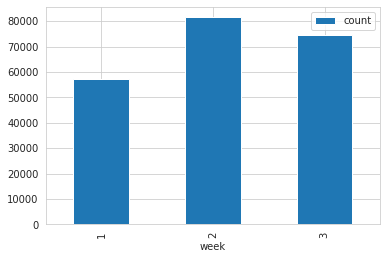

In [38]:
%%time
# interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
# interactions_per_month.name = 'count'
# interactions_per_month=interactions_per_month.reset_index()
d = _.loc[sampled_users].reset_index()
interactions_per_week = d.groupby(by=['week']).count().iloc[:, 0]
interactions_per_week.name = 'count'
interactions_per_week=interactions_per_week.reset_index()

# _ = interactions_per_month.copy()
# _['date'] = _['date'].dt.year
# _.groupby('date').sum().plot(kind='bar')
d = interactions_per_week.copy()
# _['date'] = _['date'].dt.year
d.groupby('week').sum().plot(kind='bar')

In [39]:
# %%time
# plot_interactions_per_month(data=_.loc[freq_users].reset_index(), dataset_name=dataset_name)
# plot_interactions_per_month(data=_.loc[sampled_users].reset_index(), dataset_name=dataset_name)

In [40]:
USE_THRESHOLD = False
# all users 0.009364
# USING prop 0.75 0.003883
# USING prop 0.5 0.003254

if USE_THRESHOLD: 
    data = _.loc[sampled_users].reset_index()
    data = data.sort_values(by=['timestamp', 'user_id', 'item_id'])
    print(data.shape[0])
else:
    print(data.shape[0])
# new sample
data.to_csv('output/amazonbooks_dump/3rd_sampled_amazon_books.csv', index=False)

286130


What is the user presence distribution based on month, quarter, and semester?

In [41]:
%%time
user_week_interactions = data.groupby(by=[user_col, 'week']).count().iloc[:, 0]
user_week_interactions.name = 'count'
user_week_interactions = user_week_interactions.reset_index()
user_week_interactions.sort_values(by=['week'], ascending=[True], inplace=True)

c = 0
user_presence_percentage = []
for u in user_week_interactions[user_col].unique():
        progress = round( 100*( c/user_week_interactions[user_col].nunique() ), 4 )
        if progress%5==0:
            print( progress, '%' )
        c+=1
        uidx = user_week_interactions[user_col] == u
        week_presence = user_week_interactions.loc[uidx, 'week'].nunique() / user_week_interactions['week'].nunique()
        user_presence_percentage.append([u, week_presence])

0.0 %
5.0 %
10.0 %
15.0 %
20.0 %
25.0 %
30.0 %
35.0 %
40.0 %
45.0 %
50.0 %
55.0 %
60.0 %
65.0 %
70.0 %
75.0 %
80.0 %
85.0 %
90.0 %
95.0 %
CPU times: user 4h 1min 16s, sys: 2.99 s, total: 4h 1min 19s
Wall time: 4h 1min 30s


In [42]:
user_presence_df = pd.DataFrame(
    user_presence_percentage,
    columns= ['UserID', 'week_%']
    ).sort_values(by='week_%', ascending=False)

In [43]:
user_presence_df.to_csv('output/amazonbooks_dump/3rd_sample_user_presence_df.csv', index=False)
user_week_interactions.to_csv('output/amazonbooks_dump/3rd_sample_user_week_interactions.csv', index=False)

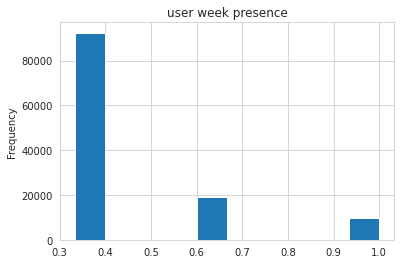

In [44]:
# fig, ax = plt.subplots(1,3, figsize=(17,4))
user_presence_df['week_%'].plot(kind='hist', title='user week presence')
plt.savefig(f'images/user_bucket_analysis/{dataset_name}_user_presence_distribution.png');

How many FREQUENT users (occur in 80% or more intervals) exist?

In [45]:
# defining threshold
frequency_threshold = 1

In [46]:
frequent_users_week = user_presence_df[user_presence_df['week_%']>=frequency_threshold ]['UserID'].values
# percentage of users that are *frequent in months
print(
f'''{len(frequent_users_week)} users \
of {user_presence_df['UserID'].nunique()} \
({round( 100*len(frequent_users_week) / user_presence_df.shape[0], 3)}%) occurr in {frequency_threshold*100}% or more weeks.''' #  (of {user_month_interactions["date"].nunique()})
)

9513 users of 121060 (7.858%) occurr in 100% or more weeks.


In [47]:
# # new sample
joblib.dump(frequent_users_week, 'output/amazonbooks_dump/3rd_sample_frequent_users_week.joblib')

['output/amazonbooks_dump/3rd_sample_frequent_users_week.joblib']

In [50]:
data.shape, data.user_id.nunique(), data.item_id.nunique()

((286130, 5), 121060, 209592)

In [54]:
data[['user_id', 'item_id']].duplicated().sum()

988